In [1]:
!pip3 install dask
!pip install graphviz
!pip install folium
!pip install gpxpy
!pip install gensim
!pip install prettytable
!pip install sklearn

    100% |████████████████████████████████| 112kB 2.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/7c/81/7f/effefbec600ee0ba7f29a29e38754a6e4e1e956538929fdbfd
Successfully built gpxpy


In [2]:
!pip install dask[complete]

  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built locket


In [0]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import GaussianNB
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.linear_model import SGDClassifier

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
con = sqlite3.connect(r'/content/drive/My Drive/database.sqlite') 

In [6]:
filteredData = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)
#filteredData=filteredData.iloc[0:3000,:]
#filteredData.shape               
dfScore=filteredData['Score']

def convertPositiveNegative(x):
    if x < 3:
        return 'negative'
    return 'positive'
dfPositiveNegative=dfScore.map(convertPositiveNegative)


filteredData['Score']=dfPositiveNegative
print(filteredData.head(5))

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitalit

In [0]:
sorted_data=filteredData.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [9]:
(final['Id'].size*1.0)/(filteredData['Id'].size*1.0)*100

69.25890143662969

In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape
print(final.head(5))

            Id   ProductId          UserId                  ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
138706                     0                       0  positive   939340800   
138688                     1                       1  positive  1194739200   
138689                     1                       1  positive  1191456000   
138690                     1                       1  positive  1076025600   
138691                     3                       4  positive  1018396800   

                                           Summary  \
138706                   E

In [11]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
                
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string

In [0]:
final=final.sort_values(by='Time')

In [15]:
final=final.iloc[0:60000,:]
final.shape

(60000, 11)

In [0]:
final['Score_num']=final.Score.map({'positive':1, 'negative':0})
Y=final['Score_num']

In [0]:
lst=["negative","positive"]

In [0]:
X_train=final.iloc[0:45000]
Y_train=final['Score_num'].iloc[0:45000]

In [0]:
X_test=final.iloc[45001:60000]
Y_test=final['Score_num'].iloc[45001:60000]

# tfidF

In [0]:
count_vect = TfidfVectorizer() #in scikit-learn
X_train_vect = count_vect.fit_transform(X_train['CleanedText'].values)

In [0]:
X_test_vect=count_vect.transform(X_test['CleanedText'].values)

In [0]:
from sklearn.preprocessing import Normalizer
transformer_tfidf = Normalizer().fit(X_train_vect)
X_train_vect_norm_tfidf=transformer_tfidf.transform(X_train_vect)

In [0]:
X_test_vect_norm_tfidf=transformer_tfidf.transform(X_test_vect)

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import tree

In [25]:
tuned_parameters = [{'max_depth': [1,5,10,50,100,500,1000],'min_samples_split': [5,10,100,500]}]
cv_scores = []
clf = DecisionTreeClassifier(criterion='gini', splitter='best')
model_auc_tfidf = GridSearchCV(clf,tuned_parameters, cv=5,return_train_score='True',scoring='roc_auc')
model_auc_tfidf.fit(X_train_vect_norm_tfidf, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)

In [26]:
print("best estimator",model_auc_tfidf.best_estimator_)
print("Score",model_auc_tfidf.score(X_test_vect_norm_tfidf, Y_test))
print(model_auc_tfidf.best_params_)

best estimator DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Score 0.7936884616376826
{'max_depth': 50, 'min_samples_split': 500}


In [0]:
cv_auc_train = model_auc_tfidf.cv_results_['mean_train_score']
cv_auc_cv=model_auc_tfidf.cv_results_['mean_test_score']

In [28]:
print(cv_auc_train)
print(cv_auc_cv)

[0.54496204 0.54496204 0.54496204 0.54496204 0.63675715 0.63668825
 0.63597767 0.63434501 0.7305411  0.72986483 0.7242542  0.71953957
 0.93795691 0.93484775 0.91624857 0.89204639 0.97888766 0.97699482
 0.9618295  0.93895834 0.99971595 0.99867652 0.98854406 0.97333509
 0.99971342 0.99864915 0.98853906 0.97329087]
[0.54443571 0.54443571 0.54443571 0.54443571 0.6196661  0.61963599
 0.620786   0.62213555 0.6857747  0.68900219 0.69859779 0.70385355
 0.68619803 0.69670942 0.76611039 0.80093125 0.65704142 0.66683739
 0.73550945 0.79333778 0.66390189 0.67667057 0.72056062 0.75348821
 0.66420595 0.67911791 0.72247102 0.75409795]


In [0]:
tuned_parameters_dict=tuned_parameters[0]
tuned_parameters_list_depth=tuned_parameters_dict['max_depth']

tuned_parameters_list_split=tuned_parameters_dict['min_samples_split']


In [0]:
max_depth=[]
min_samples_split=[]
for data in model_auc_tfidf.cv_results_['params'] :
  max_depth.append(data['max_depth'])    
  min_samples_split.append(data['min_samples_split'])

In [0]:
df_train_tfidf = pd.DataFrame(
    {'max_depth': max_depth,
     'min_samples_split': min_samples_split,
     'cv_auc_train': cv_auc_train
    })


In [0]:
df_train_tfidf = df_train_tfidf.pivot("max_depth", "min_samples_split", "cv_auc_train")

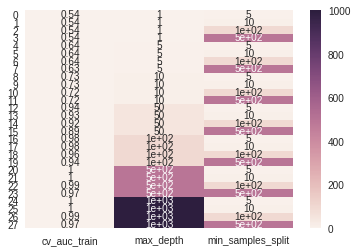

In [98]:
ax = sns.heatmap(df_train_tfidf,annot=True)

In [0]:
df_cv_tfidf = pd.DataFrame(
    {'max_depth': max_depth,
     'min_samples_split': min_samples_split,
     'cv_auc_cv': cv_auc_cv
    })
df_cv_tfidf = df_cv_tfidf.pivot("max_depth", "min_samples_split", "cv_auc_cv")

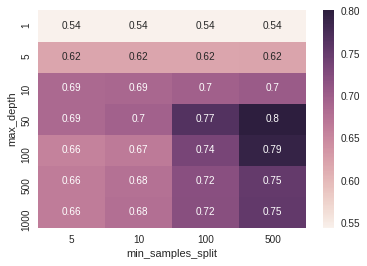

In [100]:
ax = sns.heatmap(df_cv_tfidf,annot=True)

In [0]:
clf_model_tfidf = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=50,min_samples_split=500)

clf_model_tfidf.fit(X_train_vect_norm_tfidf, Y_train)

Y_predict_tfidf=clf_model_tfidf.predict(X_test_vect_norm_tfidf)

Y_prob_tfidf=clf_model_tfidf.predict_proba(X_test_vect_norm_tfidf)


In [0]:
feature_weights_tfidf=clf_model_tfidf.feature_importances_


In [0]:
indices_tfidf = np.argsort(feature_weights_tfidf)[::-1][:20]

In [0]:
tfidf_features = count_vect.get_feature_names()

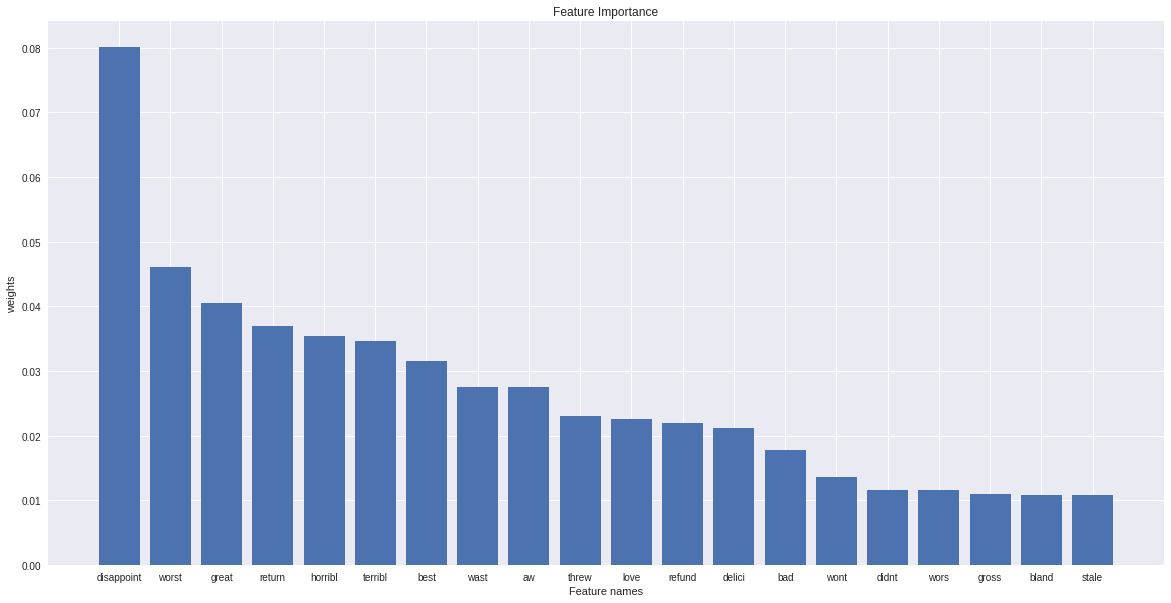

In [42]:
plt.figure(figsize=(20,10))
#plt.figure()
plt.title("Feature Importance")
plt.bar(range(20), feature_weights_tfidf[indices_tfidf])

# Add feature names as x-axis labels
tfidf_features = np.array(tfidf_features)
plt.xticks(range(20), tfidf_features[indices_tfidf])
plt.xlabel('Feature names')
plt.ylabel('weights')
# Show plot
plt.show()
# uni_gram.get_feature_names()
    

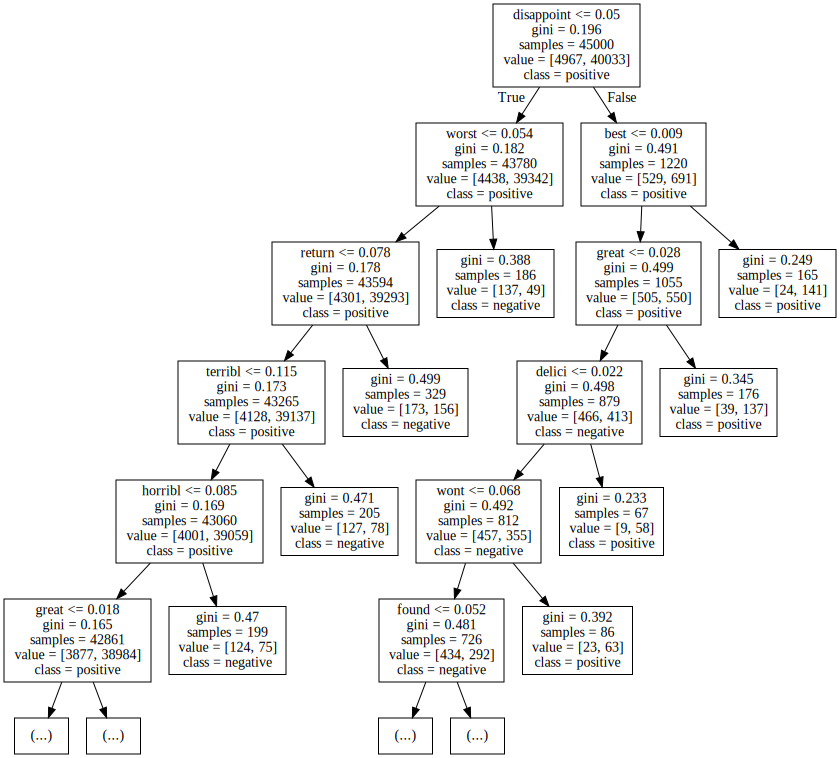

In [43]:
import graphviz
dot_data = tree.export_graphviz(clf_model_tfidf, out_file=None,class_names=lst,max_depth=5,feature_names=tfidf_features)
graph = graphviz.Source(dot_data) 
#graph.render("final")
graph

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob_tfidf[:,1])

In [45]:
print("AUC",metrics.auc(fpr, tpr))

AUC 0.7933602718647819


In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    labels = [1,2]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

-------------------- Confusion matrix --------------------


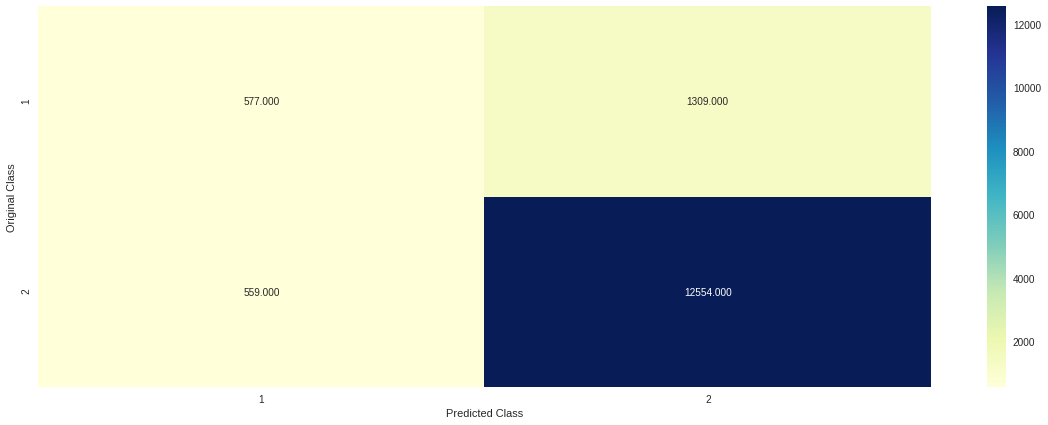

-------------------- Precision matrix (Columm Sum=1) --------------------


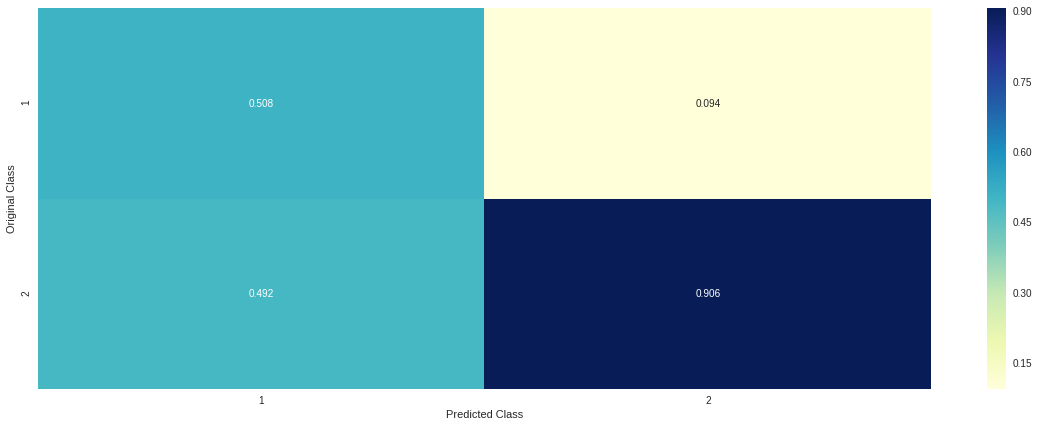

-------------------- Recall matrix (Row sum=1) --------------------


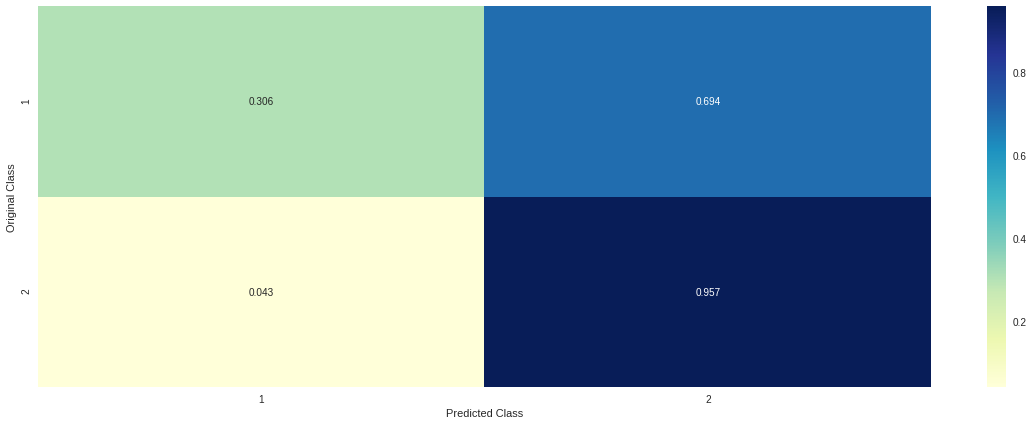

In [49]:
plot_confusion_matrix(Y_test,Y_predict_tfidf)

#BOW

In [0]:
count_vect_bow=CountVectorizer() #in scikit-learn
X_train_vect_bow = count_vect_bow.fit_transform(X_train['CleanedText'].values)

In [0]:
X_test_vect_bow=count_vect_bow.transform(X_test['CleanedText'].values)

In [52]:
from sklearn.preprocessing import Normalizer
transformer_bow = Normalizer().fit(X_train_vect_bow)
print(transformer_bow)
X_train_vect_norm_bow=transformer_bow.transform(X_train_vect_bow)

Normalizer(copy=True, norm='l2')


In [0]:
X_test_vect_norm_bow=transformer_bow.transform(X_test_vect_bow)

In [54]:
tuned_parameters = [{'max_depth': [1,5,10,50,100,500,1000],'min_samples_split': [5,10,100,500]}]

clf_bow = DecisionTreeClassifier(criterion='gini', splitter='best')

model_auc_bow = GridSearchCV(clf_bow,tuned_parameters, cv=5,return_train_score='True',scoring='roc_auc')
model_auc_bow.fit(X_train_vect_norm_bow, Y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)

In [55]:
cv_auc_train_bow = model_auc_bow.cv_results_['mean_train_score']
cv_auc_cv_bow=model_auc_bow.cv_results_['mean_test_score']
print(cv_auc_train_bow)
print(cv_auc_cv_bow)

[0.54507425 0.54507425 0.54507425 0.54507425 0.64770542 0.64761415
 0.64703457 0.6454297  0.73910831 0.73855932 0.73342667 0.72868335
 0.93151334 0.92842708 0.90981963 0.88184245 0.97470794 0.97292175
 0.95699138 0.931178   0.99966287 0.99851192 0.98756368 0.9697877
 0.99965546 0.99854587 0.98768123 0.96980976]
[0.54454816 0.54454816 0.54454816 0.54454816 0.63285438 0.63308837
 0.63526965 0.63556157 0.69460392 0.69864474 0.70834323 0.71226872
 0.67104575 0.68678805 0.75595646 0.80309049 0.63855481 0.65502022
 0.74060089 0.7973141  0.66841527 0.6788329  0.72490272 0.76015629
 0.66943067 0.67832006 0.72896568 0.75872682]


In [56]:
print("Score",model_auc_bow.score(X_test_vect_norm_bow,Y_test))
print("Best parameters",model_auc_bow.best_params_)

Score 0.7935720293761082
Best parameters {'max_depth': 50, 'min_samples_split': 500}


In [0]:
df_train_bow = pd.DataFrame(
    {'max_depth': max_depth,
     'min_samples_split': min_samples_split,
     'cv_auc_train_bow': cv_auc_train_bow
    })

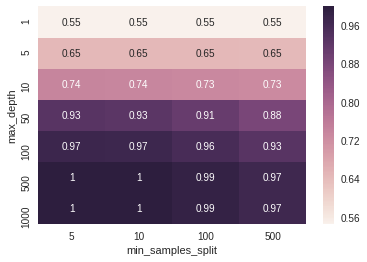

In [102]:
df_train_bow = df_train_bow.pivot("max_depth", "min_samples_split", "cv_auc_train_bow")

ax = sns.heatmap(df_train_bow,annot=True)

In [0]:
df_cv_bow = pd.DataFrame(
    {'max_depth': max_depth,
     'min_samples_split': min_samples_split,
     'cv_auc_cv_bow': cv_auc_cv_bow
    })
df_cv_bow = df_cv_bow.pivot("max_depth", "min_samples_split", "cv_auc_cv_bow")

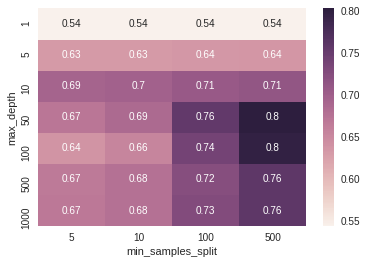

In [104]:
ax = sns.heatmap(df_cv_bow,annot=True)

In [0]:
clf_model_bow = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=50,min_samples_split=500)

clf_model_bow.fit(X_train_vect_norm_bow, Y_train)

Y_predict_bow=clf_model_bow.predict(X_test_vect_norm_bow)
Y_prob_bow=clf_model_bow.predict_proba(X_test_vect_norm_bow)

In [58]:

fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob_bow[:,1])
print("AUC",metrics.auc(fpr, tpr))

AUC 0.7922252443257922


In [0]:
feature_weights_bow=clf_model_bow.feature_importances_
bow_features = count_vect_bow.get_feature_names()

indices_bow = np.argsort(feature_weights_bow)[::-1][:20]


In [61]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob_bow[:,1])
print("AUC",metrics.auc(fpr, tpr))

AUC 0.7922252443257922


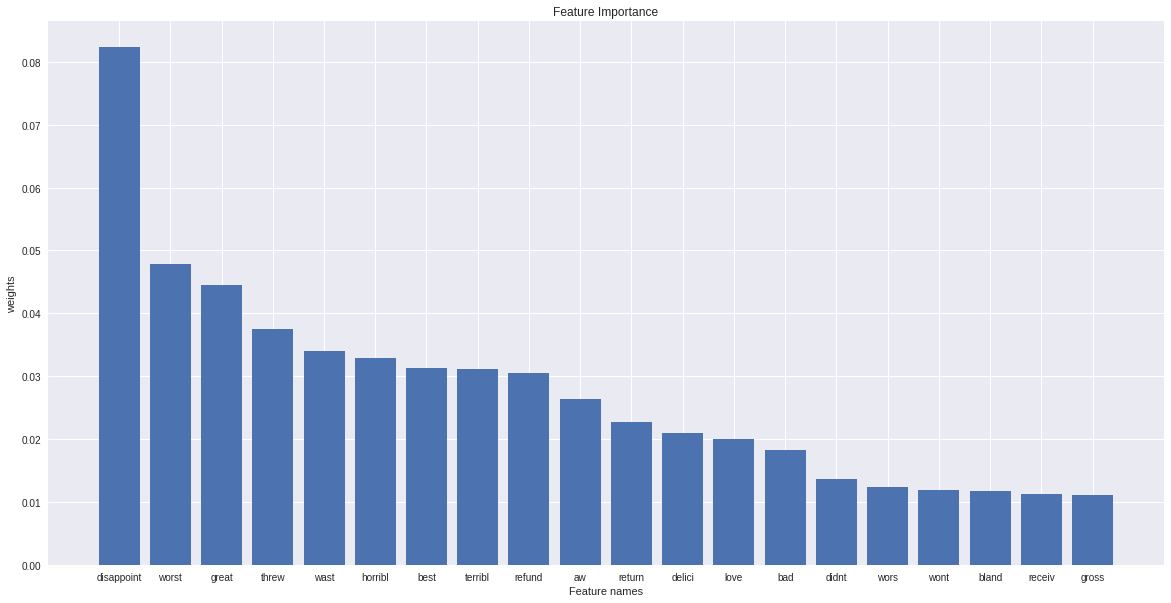

In [62]:
plt.figure(figsize=(20,10))
#plt.figure()
plt.title("Feature Importance")
plt.bar(range(20), feature_weights_bow[indices_bow])

# Add feature names as x-axis labels
bow_features = np.array(bow_features)
plt.xticks(range(20), bow_features[indices_bow])
plt.xlabel('Feature names')
plt.ylabel('weights')
# Show plot
plt.show()
# uni_gram.get_feature_names()

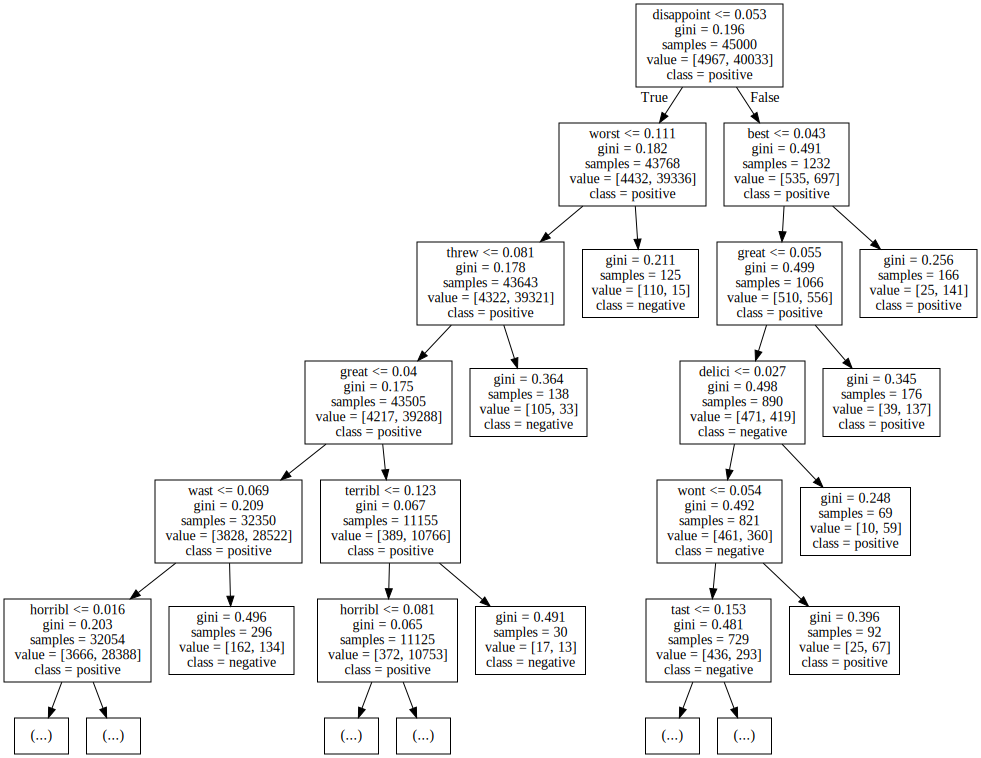

In [63]:
import graphviz
dot_data = tree.export_graphviz(clf_model_bow, out_file=None,class_names=lst,max_depth=5,feature_names=bow_features)
graph = graphviz.Source(dot_data) 
#graph.render("final")
graph

-------------------- Confusion matrix --------------------


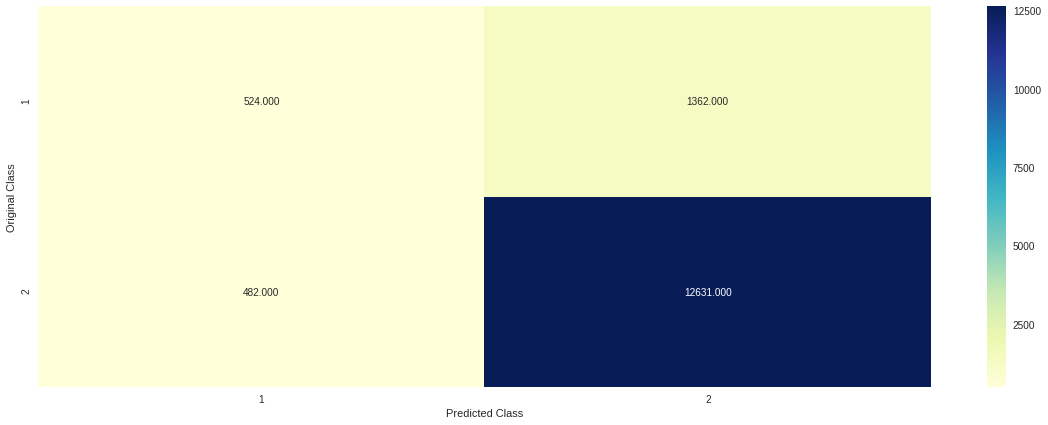

-------------------- Precision matrix (Columm Sum=1) --------------------


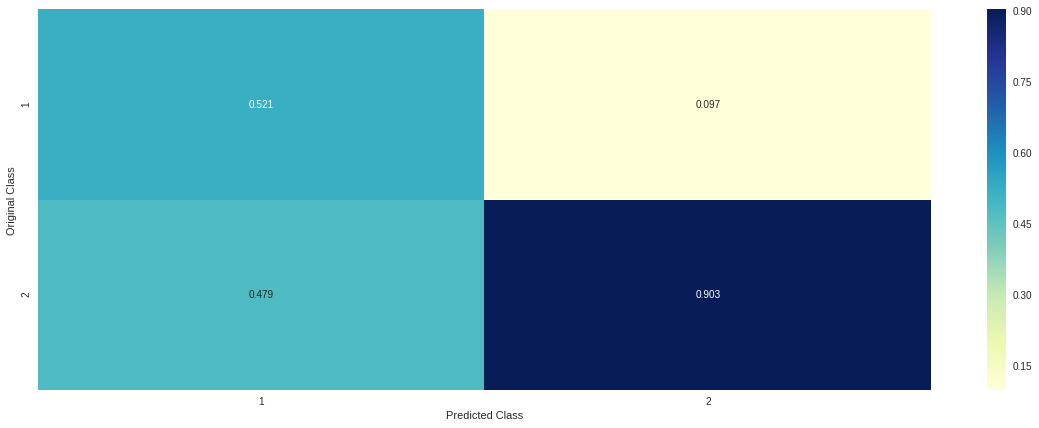

-------------------- Recall matrix (Row sum=1) --------------------


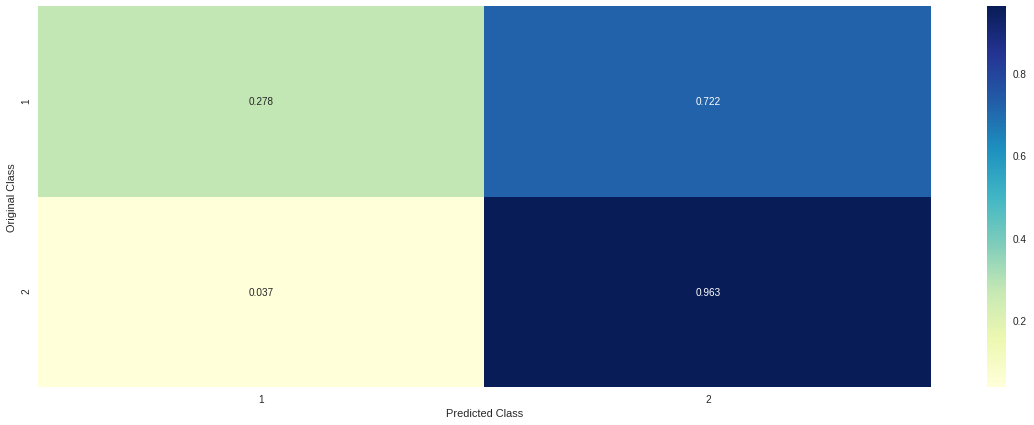

In [64]:
plot_confusion_matrix(Y_test,Y_predict_bow)

# word2vec

In [0]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [0]:
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [0]:
X_train_word2vec=final.iloc[0:45000]
Y_train_word2vec=final['Score_num'].iloc[0:45000]

X_test_word2vec=final.iloc[45001:60000]
Y_test_word2vec=final['Score_num'].iloc[45001:60000]

In [0]:
list_of_sent_X_train_word2vec=[]
list_of_sent_X_test_word2vec=[]

for sent in X_train_word2vec['CleanedText'].values:
    list_of_sent_X_train_word2vec.append(sent.split())
    


for sent in X_test_word2vec['CleanedText'].values:
    list_of_sent_X_test_word2vec.append(sent.split())

In [0]:
w2v_model=Word2Vec(list_of_sent_X_train_word2vec,min_count=5,size=50, workers=4)

In [0]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_train_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

In [0]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_test_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

In [0]:
from sklearn.preprocessing import Normalizer
transformer_word2vec = Normalizer().fit(sent_vectors_train)
X_train_vect_norm_word2vec=transformer_word2vec.transform(sent_vectors_train)
X_test_vect_norm_word2vec=transformer_word2vec.transform(sent_vectors_test)

In [73]:
print(X_train_vect_norm_word2vec.shape)
print(X_test_vect_norm_word2vec.shape)
print(Y_train_word2vec.shape)

(45000, 50)
(14999, 50)
(45000,)


In [74]:
tuned_parameters = [{'max_depth': [1,5,10,50,100,500,1000],'min_samples_split': [5,10,100,500]}]

clf_word2vec = DecisionTreeClassifier(criterion='gini', splitter='best')

model_auc_word2vec = GridSearchCV(clf_word2vec,tuned_parameters, cv=5,return_train_score='True',scoring='roc_auc')
model_auc_word2vec.fit(X_train_vect_norm_word2vec, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)

In [75]:
cv_auc_train_word2vec = model_auc_word2vec.cv_results_['mean_train_score']
cv_auc_cv_word2vec=model_auc_word2vec.cv_results_['mean_test_score']
print(cv_auc_train_word2vec)
print(cv_auc_train_word2vec)

[0.64343132 0.64343132 0.64343132 0.64343132 0.80337314 0.80337314
 0.80337314 0.80267455 0.89722744 0.89488309 0.87353863 0.84473233
 0.99956732 0.99663582 0.94968346 0.88175831 0.9995438  0.99663448
 0.949571   0.88184716 0.99955566 0.99665806 0.94962524 0.88171395
 0.99956021 0.99666219 0.94967649 0.88167097]
[0.64343132 0.64343132 0.64343132 0.64343132 0.80337314 0.80337314
 0.80337314 0.80267455 0.89722744 0.89488309 0.87353863 0.84473233
 0.99956732 0.99663582 0.94968346 0.88175831 0.9995438  0.99663448
 0.949571   0.88184716 0.99955566 0.99665806 0.94962524 0.88171395
 0.99956021 0.99666219 0.94967649 0.88167097]


In [76]:
print("Score",model_auc_word2vec.score(X_test_vect_norm_word2vec,Y_test))
print("Best parameters",model_auc_word2vec.best_params_)

Score 0.7717101588371379
Best parameters {'max_depth': 10, 'min_samples_split': 500}


In [0]:
df_train_word2vec = pd.DataFrame(
    {'max_depth': max_depth,
     'min_samples_split': min_samples_split,
     'cv_auc_train_word2vec': cv_auc_train_word2vec
    })

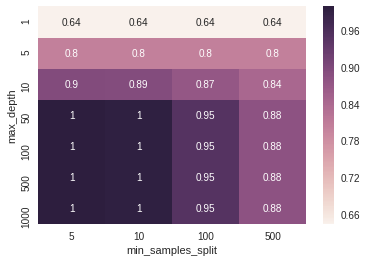

In [106]:
df_train_word2vec = df_train_word2vec.pivot("max_depth", "min_samples_split", "cv_auc_train_word2vec")

ax = sns.heatmap(df_train_word2vec,annot=True)

In [0]:
df_cv_word2vec = pd.DataFrame(
    {'max_depth': max_depth,
     'min_samples_split': min_samples_split,
     'cv_auc_cv_word2vec': cv_auc_cv_word2vec
    })

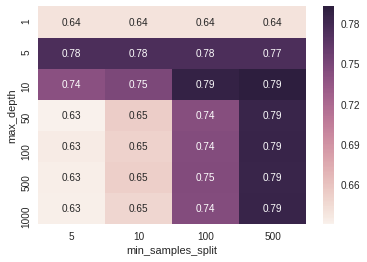

In [108]:
df_cv_word2vec = df_cv_word2vec.pivot("max_depth", "min_samples_split", "cv_auc_cv_word2vec")

ax = sns.heatmap(df_cv_word2vec,annot=True)

In [0]:
clf_model_word2vec = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=10,min_samples_split=500)

clf_model_word2vec.fit(X_train_vect_norm_word2vec, Y_train)

Y_predict_word2vec=clf_model_word2vec.predict(X_test_vect_norm_word2vec)
Y_prob_word2vec=clf_model_word2vec.predict_proba(X_test_vect_norm_word2vec)

In [78]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob_word2vec[:,1])
print("AUC",metrics.auc(fpr, tpr))

AUC 0.7717101588371379


-------------------- Confusion matrix --------------------


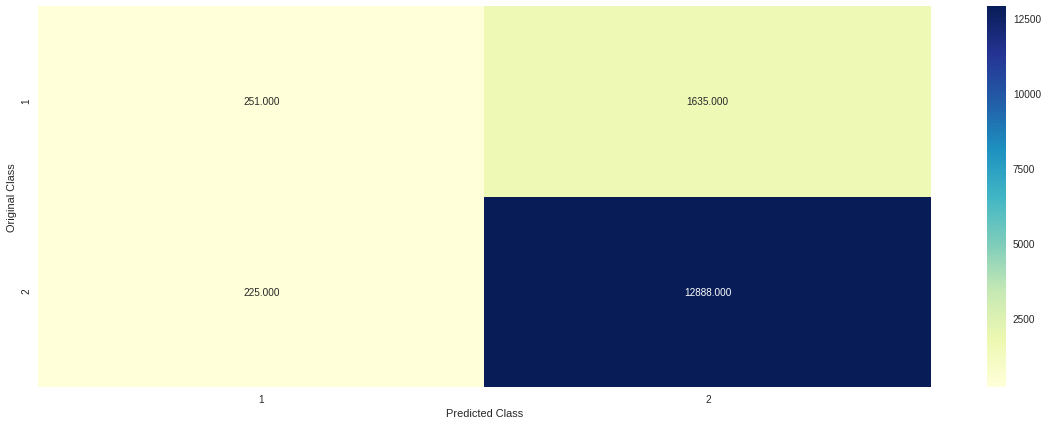

-------------------- Precision matrix (Columm Sum=1) --------------------


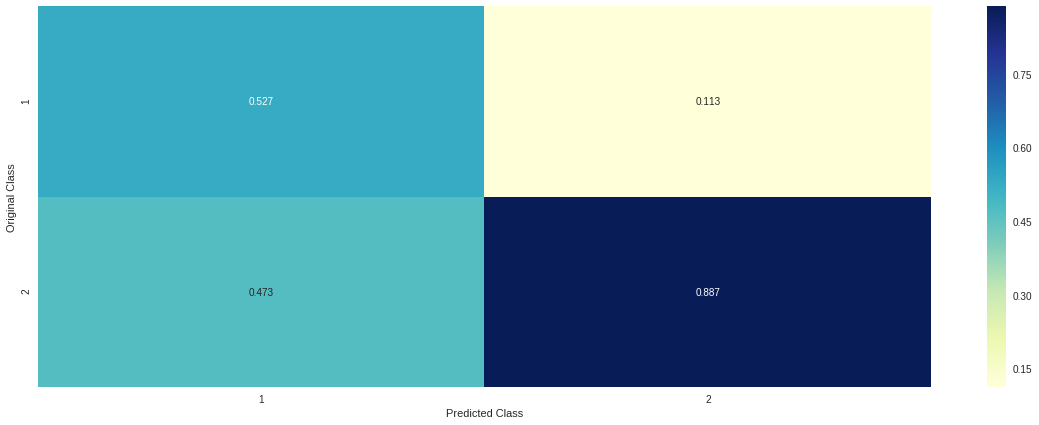

-------------------- Recall matrix (Row sum=1) --------------------


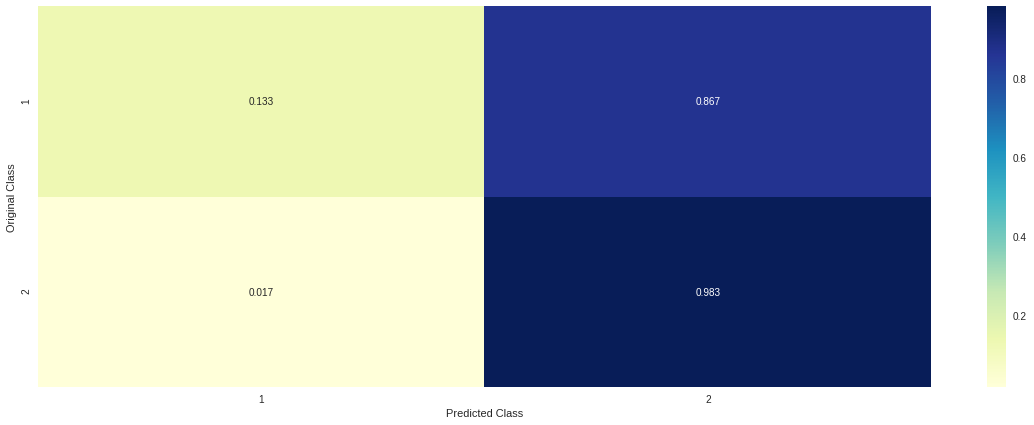

In [79]:
plot_confusion_matrix(Y_test,Y_predict_word2vec)

# tfidf word2vec

In [0]:
tfidf_feat = count_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_train_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
            
        except:
            pass
    try:    
        sent_vec /= weight_sum
    except ZeroDivisionError:
        sent_vec=0
        
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [0]:
tfidf_feat = count_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_test_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    try:    
        sent_vec /= weight_sum
    except ZeroDivisionError:
        sent_vec=0
    #print(sent_vec)
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [82]:
from sklearn.preprocessing import Normalizer
transformer_tfidfword2vec = Normalizer().fit(tfidf_sent_vectors_train)
print(transformer_word2vec)
tfidf_sent_vectors_train_norm=transformer_tfidfword2vec.transform(tfidf_sent_vectors_train)


Normalizer(copy=True, norm='l2')


In [0]:
tfidf_sent_vectors_test_norm=transformer_tfidfword2vec.transform(tfidf_sent_vectors_test)

In [84]:
tuned_parameters = [{'max_depth': [1,5,10,50,100,500,1000],'min_samples_split': [5,10,100,500]}]

clf_tfidfword2vec = DecisionTreeClassifier(criterion='gini', splitter='best')

clf_tfidfword2vec = GridSearchCV(clf_tfidfword2vec,tuned_parameters, cv=5,return_train_score='True',scoring='roc_auc')
clf_tfidfword2vec.fit(tfidf_sent_vectors_train_norm, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)

In [85]:
cv_auc_train_tfidfword2vec = clf_tfidfword2vec.cv_results_['mean_train_score']
cv_auc_cv_tfidfword2vec=clf_tfidfword2vec.cv_results_['mean_test_score']
print(cv_auc_train_tfidfword2vec)
print(cv_auc_train_tfidfword2vec)

[0.6342033  0.6342033  0.6342033  0.6342033  0.77286285 0.77286285
 0.7728192  0.77182396 0.87417759 0.87157041 0.85145384 0.82346345
 0.99946535 0.99608124 0.94376473 0.869699   0.9994603  0.99608332
 0.94379231 0.86956732 0.99945685 0.99611999 0.94380515 0.86962434
 0.99946592 0.99611232 0.94384062 0.86943573]
[0.6342033  0.6342033  0.6342033  0.6342033  0.77286285 0.77286285
 0.7728192  0.77182396 0.87417759 0.87157041 0.85145384 0.82346345
 0.99946535 0.99608124 0.94376473 0.869699   0.9994603  0.99608332
 0.94379231 0.86956732 0.99945685 0.99611999 0.94380515 0.86962434
 0.99946592 0.99611232 0.94384062 0.86943573]


In [86]:
print("Score",model_auc_word2vec.score(tfidf_sent_vectors_test_norm,Y_test))
print("Best parameters",model_auc_word2vec.best_params_)

Score 0.7346055079273004
Best parameters {'max_depth': 10, 'min_samples_split': 500}


In [0]:
df_train_tfidfword2vec = pd.DataFrame(
    {'max_depth': max_depth,
     'min_samples_split': min_samples_split,
     'cv_auc_train_tfidfword2vec': cv_auc_train_tfidfword2vec
    })

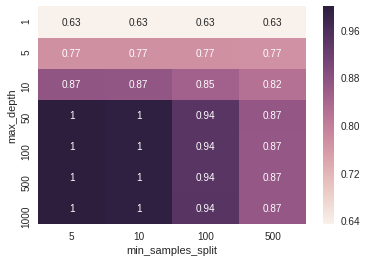

In [110]:
df_train_tfidfword2vec = df_train_tfidfword2vec.pivot('max_depth','min_samples_split','cv_auc_train_tfidfword2vec')

ax = sns.heatmap(df_train_tfidfword2vec,annot=True)

In [0]:
df_cv_tfidfword2vec = pd.DataFrame(
    {'max_depth': max_depth,
     'min_samples_split': min_samples_split,
     'cv_auc_cv_tfidfword2vec': cv_auc_cv_tfidfword2vec
    })

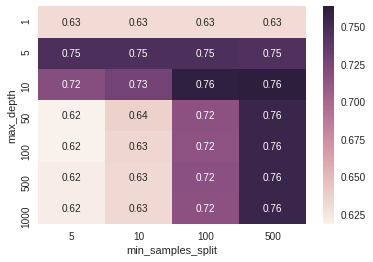

In [112]:
df_cv_tfidfword2vec = df_cv_tfidfword2vec.pivot("max_depth", "min_samples_split", "cv_auc_cv_tfidfword2vec")

ax = sns.heatmap(df_cv_tfidfword2vec,annot=True)

In [0]:
clf_model_tfidfword2vec = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=10,min_samples_split=500)

clf_model_tfidfword2vec.fit(tfidf_sent_vectors_train_norm, Y_train)

Y_predict_tfidfword2vec=clf_model_tfidfword2vec.predict(tfidf_sent_vectors_test_norm)
Y_prob_tfidfword2vec=clf_model_tfidfword2vec.predict_proba(tfidf_sent_vectors_test_norm)

In [88]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob_tfidfword2vec[:,1])
print("AUC",metrics.auc(fpr, tpr))

AUC 0.7474061018996392


-------------------- Confusion matrix --------------------


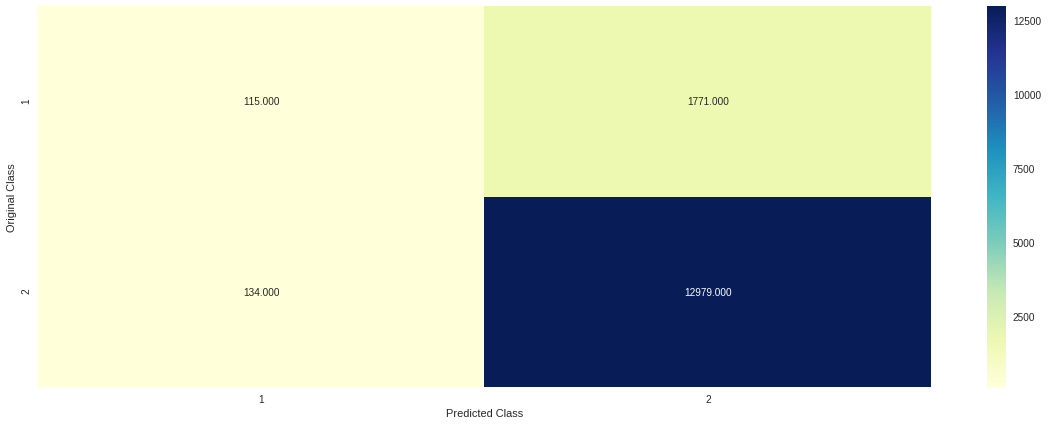

-------------------- Precision matrix (Columm Sum=1) --------------------


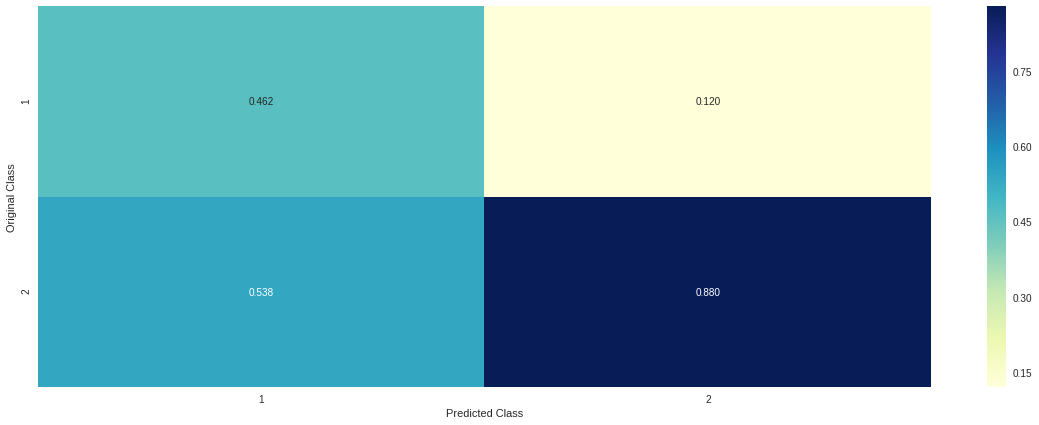

-------------------- Recall matrix (Row sum=1) --------------------


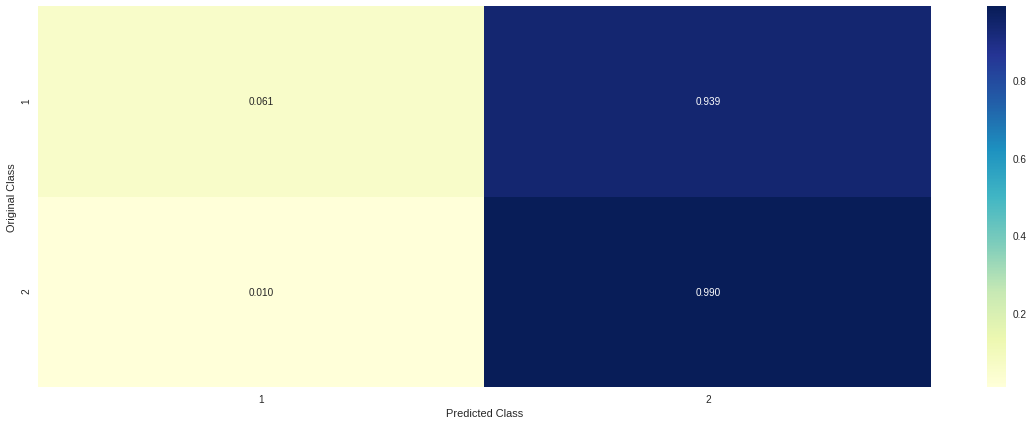

In [89]:
plot_confusion_matrix(Y_test,Y_predict_tfidfword2vec)

# conclusion

In [0]:
from prettytable import PrettyTable
x = PrettyTable()

In [0]:
x.field_names = ["Type of vectorizer", "max_depth","min_samples_split","auc"]

In [0]:
x.add_row(["TFIDF","50","500","0.793"])
x.add_row(["BOW","50","500","0.792"])
x.add_row(["word2vec","10","500","0.797"])
x.add_row(["tfidf word2vec","10","500","0.764"])

In [116]:
print(x)

+--------------------+-----------+-------------------+-------+
| Type of vectorizer | max_depth | min_samples_split |  auc  |
+--------------------+-----------+-------------------+-------+
|       TFIDF        |     50    |        500        | 0.793 |
|        BOW         |     50    |        500        | 0.792 |
|      word2vec      |     10    |        500        | 0.797 |
|   tfidf word2vec   |     10    |        500        | 0.764 |
+--------------------+-----------+-------------------+-------+
